### The next three lines of code need to be launched (separately) if the python libraries aren't present in the Colab session 

In [ ]:
#pip install statsmodels

In [ ]:
#pip install arch

In [ ]:
#pip install yfinance

In [71]:
# Importing Python lybraries

import yfinance as yf # Public yahooh finance API.
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import acf, pacf, adfuller, q_stat
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.stats import normaltest, skew, kurtosis, chi2, norm, kendalltau, spearmanr, pearsonr
from scipy.optimize import minimize, Bounds, LinearConstraint

from arch.univariate import ARX, GARCH, arch_model

# diasble warnings

import warnings
warnings.filterwarnings('ignore')

In [72]:
# Importing time series from yahoo finance

msft = yf.Ticker("MSFT") # Get the ticker for stock Microsoft
msft_hist = msft.history(period="7y") # get historical time series correspondig the ticker. 10y = ten years

aapl = yf.Ticker('AAPL') # Ticker Apple
aapl_hist = aapl.history(period="7y") 

nvda = yf.Ticker('NVDA') # Ticker NVIDIA
nvda_hist = nvda.history(period='7y')

tsm = yf.Ticker('TSM') # Taiwan Semiconductor Manufacturing Company Ltd.
tsm_hist = tsm.history(period='7y')

baba = yf.Ticker('BABA') # ALibaba
baba_hist = baba.history(period='7y')

In [73]:
msft_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-05-25 00:00:00-04:00,63.485919,64.323557,63.430692,64.084236,21854100,0.0,0.0
2017-05-26 00:00:00-04:00,64.249935,64.636538,63.992193,64.397209,19827900,0.0,0.0
2017-05-30 00:00:00-04:00,64.240690,64.811394,64.222276,64.811394,17072800,0.0,0.0
2017-05-31 00:00:00-04:00,64.921865,65.115167,64.259114,64.286728,30436400,0.0,0.0
2017-06-01 00:00:00-04:00,64.654937,64.995519,63.927752,64.526070,21603600,0.0,0.0


In [74]:
aapl_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-05-25 00:00:00-04:00,35.975729,36.120823,35.811916,36.008492,76942400,0.0,0.0
2017-05-26 00:00:00-04:00,36.038914,36.095080,35.877441,35.947647,87710400,0.0,0.0
2017-05-30 00:00:00-04:00,35.903177,36.139534,35.882116,35.961681,80507600,0.0,0.0
2017-05-31 00:00:00-04:00,36.031883,36.078686,35.659794,35.748718,97804800,0.0,0.0
2017-06-01 00:00:00-04:00,35.844680,35.882124,35.622363,35.847019,65616400,0.0,0.0


In [75]:
nvda_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-05-25 00:00:00-04:00,34.575400,34.582809,33.696197,34.145676,60822800,0.0,0.0
2017-05-26 00:00:00-04:00,34.064170,35.879379,33.861659,35.029812,77914000,0.0,0.0
2017-05-30 00:00:00-04:00,35.489167,36.128811,35.328640,35.778118,98965200,0.0,0.0
2017-05-31 00:00:00-04:00,36.227606,36.304165,35.081679,35.649704,88731600,0.0,0.0
2017-06-01 00:00:00-04:00,35.807763,35.817640,35.197754,35.652172,50334000,0.0,0.0


In [76]:
tsm_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-05-25 00:00:00-04:00,29.171303,29.277649,29.032238,29.097679,4514900,0.0,0.0
2017-05-26 00:00:00-04:00,29.081324,29.105867,28.901357,29.048601,3109800,0.0,0.0
2017-05-30 00:00:00-04:00,29.187669,29.294015,29.024061,29.269472,4219300,0.0,0.0
2017-05-31 00:00:00-04:00,28.893171,28.925894,28.713202,28.925894,7663100,0.0,0.0
2017-06-01 00:00:00-04:00,29.204029,29.383995,29.064960,29.359455,6016100,0.0,0.0


In [77]:
baba_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-05-25 00:00:00-04:00,122.098669,122.799251,120.687637,121.990128,12486500,0.0,0.0
2017-05-26 00:00:00-04:00,122.286150,122.996601,121.467158,122.345352,7558900,0.0,0.0
2017-05-30 00:00:00-04:00,122.434162,123.223546,121.891454,122.266418,8343400,0.0,0.0
2017-05-31 00:00:00-04:00,121.999996,122.527903,120.381750,120.835648,11582200,0.0,0.0
2017-06-01 00:00:00-04:00,121.190867,122.355216,120.638298,122.325615,8901400,0.0,0.0


## Testing for correlation

In [78]:
msft_logreturns = np.log(msft_hist['Close']).diff().dropna()
aapl_logreturns = np.log(aapl_hist['Close']).diff().dropna()
nvda_logreturns = np.log(nvda_hist['Close']).diff().dropna()
tsm_logreturns = np.log(tsm_hist['Close']).diff().dropna()
baba_logreturns = np.log(baba_hist['Close']).diff().dropna()

df_log_returns = {'msft' : msft_logreturns, 'aapl' : aapl_logreturns, 
                 'nvda' : nvda_logreturns, 'tsm' : tsm_logreturns,
                 'baba' : baba_logreturns}

df_log_returns = pd.DataFrame(data=df_log_returns) # dataframe containing the log returns of each stock

i=0
j=0

n_asset = 5

kendall_corr = np.empty((n_asset, n_asset))
spearman_corr = np.empty((n_asset, n_asset))
pearson_corr = np.empty((n_asset, n_asset))

kendall_pval = np.empty((n_asset, n_asset))
spearman_pval = np.empty((n_asset, n_asset))
pearson_pval = np.empty((n_asset, n_asset))


for asset1 in df_log_returns.columns:
    for asset2 in df_log_returns.columns:
        
        kendall_test = kendalltau(np.array(df_log_returns[asset1]), np.array(df_log_returns[asset2]))
        kendall_corr[i,j] = kendall_test.statistic
        kendall_pval[i,j] = kendall_test.pvalue
        
        spearman_test = spearmanr(np.array(df_log_returns[asset1]), np.array(df_log_returns[asset2]))
        spearman_corr[i,j] = spearman_test.statistic
        spearman_pval[i,j] = spearman_test.pvalue
        
        pearson_test = pearsonr(np.array(df_log_returns[asset1]), np.array(df_log_returns[asset2]))
        pearson_corr[i,j] = pearson_test.statistic
        pearson_pval[i,j] = pearson_test.pvalue
        
        j +=1
    i+=1
    j=0
    
kendall_corr = pd.DataFrame(data=kendall_corr, columns=['msft', 'aapl', 'nvda', 'tsm','baba'], index=['msft', 'aapl', 'nvda', 'tsm','baba'])
spearman_corr = pd.DataFrame(data=spearman_corr, columns=['msft', 'aapl', 'nvda', 'tsm','baba'], index=['msft', 'aapl', 'nvda', 'tsm','baba'])
pearson_corr = pd.DataFrame(data=pearson_corr, columns=['msft', 'aapl', 'nvda', 'tsm','baba'], index=['msft', 'aapl', 'nvda', 'tsm','baba'])

kendall_pval = pd.DataFrame(data=kendall_pval, columns=['msft', 'aapl', 'nvda', 'tsm','baba'], index=['msft', 'aapl', 'nvda', 'tsm','baba'])
spearman_pval = pd.DataFrame(data=spearman_pval, columns=['msft', 'aapl', 'nvda', 'tsm','baba'], index=['msft', 'aapl', 'nvda', 'tsm','baba'])
pearson_pval = pd.DataFrame(data=pearson_pval, columns=['msft', 'aapl', 'nvda', 'tsm','baba'], index=['msft', 'aapl', 'nvda', 'tsm','baba']) 


In [79]:
print('Kendall tau statistic')
print(kendall_corr)
print()
print('Spearman-rho tau statistic')
print(spearman_corr)
print()
print('Pearson-rho tau statistic')
print(pearson_corr)
print()

Kendall tau statistic
          msft      aapl      nvda       tsm      baba
msft  1.000000  0.511654  0.470634  0.381336  0.286196
aapl  0.511654  1.000000  0.425216  0.380359  0.279545
nvda  0.470634  0.425216  1.000000  0.461203  0.291883
tsm   0.381336  0.380359  0.461203  1.000000  0.287080
baba  0.286196  0.279545  0.291883  0.287080  1.000000

Spearman-rho tau statistic
          msft      aapl      nvda       tsm      baba
msft  1.000000  0.685856  0.643711  0.533342  0.408898
aapl  0.685856  1.000000  0.586803  0.532920  0.403467
nvda  0.643711  0.586803  1.000000  0.636342  0.415350
tsm   0.533342  0.532920  0.636342  1.000000  0.410688
baba  0.408898  0.403467  0.415350  0.410688  1.000000

Pearson-rho tau statistic
          msft      aapl      nvda       tsm      baba
msft  1.000000  0.734888  0.676906  0.552963  0.371223
aapl  0.734888  1.000000  0.612036  0.548549  0.386510
nvda  0.676906  0.612036  1.000000  0.643232  0.391310
tsm   0.552963  0.548549  0.643232  1.00000

In [80]:
print('Kendall tau P-Values')
print(kendall_pval)
print()
print('Spearman-rho tau P-Values')
print(spearman_pval)
print()
print('Pearson-rho tau P-Values')
print(pearson_pval)
print()

Kendall tau P-Values
               msft           aapl           nvda            tsm          baba
msft   0.000000e+00  4.015727e-227  1.731868e-192  4.568247e-127  2.058346e-72
aapl  4.015727e-227   0.000000e+00  1.650058e-157  1.986845e-126  3.578838e-69
nvda  1.731868e-192  1.650058e-157   0.000000e+00  6.244148e-185  3.025630e-75
tsm   4.568247e-127  1.986845e-126  6.244148e-185   0.000000e+00  7.550135e-73
baba   2.058346e-72   3.578838e-69   3.025630e-75   7.550135e-73  0.000000e+00

Spearman-rho tau P-Values
               msft           aapl           nvda            tsm          baba
msft   0.000000e+00  4.528280e-245  1.256585e-206  5.074235e-130  6.067874e-72
aapl  4.528280e-245   0.000000e+00  1.906965e-163  8.824903e-130  6.413113e-70
nvda  1.256585e-206  1.906965e-163   0.000000e+00  1.610246e-200  2.134641e-74
tsm   5.074235e-130  8.824903e-130  1.610246e-200   0.000000e+00  1.282115e-72
baba   6.067874e-72   6.413113e-70   2.134641e-74   1.282115e-72  0.000000e+00

Pea

From the p-values that are basically all zero we reject the null hyposthesis of independence

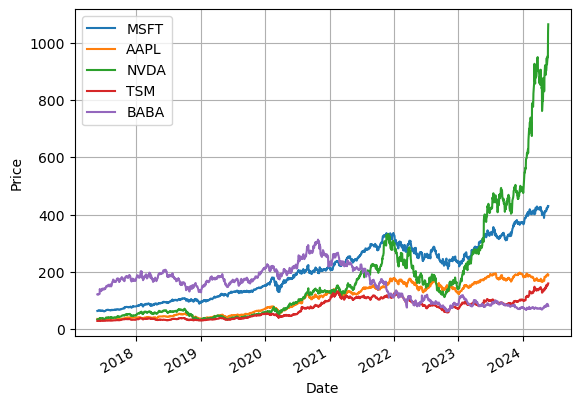

In [81]:
msft_hist['Close'].plot()
aapl_hist['Close'].plot()
nvda_hist['Close'].plot()
tsm_hist['Close'].plot()
baba_hist['Close'].plot()
plt.legend(['MSFT','AAPL','NVDA','TSM','BABA'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()

# Makowitz mean-variance analysis

### Minimum variance portofolio

In the minimum variance portfolio the aim is to solve the problem: $$\min_{w} w^{'}\Sigma w$$

where, $w$ is the vector containing the weights and $\Sigma$ is the variance covariance matrix

In [101]:
# Let's fit the GARCH(1,1) model for each stock

trading_days = list(df_log_returns.index)
vol_model = GARCH(p=1, q=1) # defining the volatility process 

start = 1000 # index for the start of the rolling window

keys = list(df_log_returns.columns)
values = [];

for _ in range(0, len(keys)):
    
    values.append(np.empty(len(trading_days)-start))

dict_forecast_vol = dict(zip(keys, values))

fitted_params = dict(zip(keys, values))

del keys
del values

for index in range(start, len(trading_days)):
    
    day = trading_days[index]

    for asset in df_log_returns.columns:
    
        r = df_log_returns.loc[:day, asset]
        
        model = arch_model(y=r);
        model.volatility = vol_model
        
        fitted_model = model.fit(disp=False)
        
        #fitted_params[asset].append(fitted_model.params)
        
        # print(asset)
        # print(fitted_model.params)
        # print()
        # forecasting the volatility
        forecasts = fitted_model.forecast(horizon=1)
        
        vol_forecast = np.sqrt(float(forecasts._variance.iloc[-1]))
        dict_forecast_vol[asset][index-start] = vol_forecast

df_vol_forecast = pd.DataFrame(data=dict_forecast_vol, index=trading_days[start:])
print(df_vol_forecast.head())
del dict_forecast_vol

                               msft      aapl      nvda       tsm      baba
2021-05-18 00:00:00-04:00  0.016815  0.017266  0.025219  0.021985  0.022193
2021-05-19 00:00:00-04:00  0.015260  0.016544  0.023161  0.020291  0.022163
2021-05-20 00:00:00-04:00  0.015073  0.016880  0.026923  0.018429  0.021810
2021-05-21 00:00:00-04:00  0.014264  0.016949  0.026601  0.017907  0.022501
2021-05-24 00:00:00-04:00  0.016292  0.016552  0.029727  0.017558  0.021940


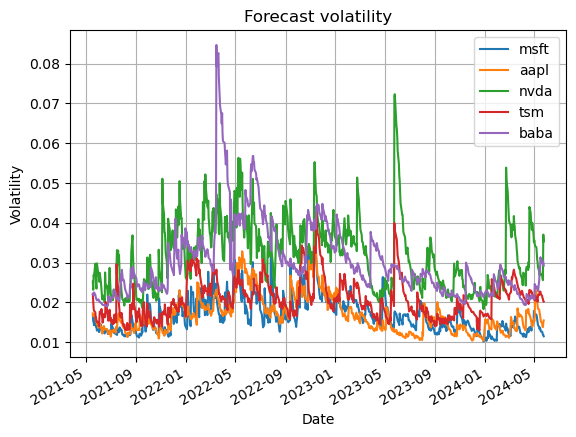

In [102]:
df_vol_forecast.plot()
plt.title('Forecast volatility')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

In [103]:
def varince_matrix_constructor(vola_series, correlation_dataframe):
    # vola_series = pandas series whose index are the columns of correlation_dataframe 
    # correlation_dataframe = pandas dataframe whose index are equal to the columns
    result = np.empty((len(vola_series), len(vola_series)))
    
    i = 0
    j = 0
    
    for asset1 in correlation_dataframe.columns:
        for asset2 in correlation_dataframe.columns:
            
            vol1 = float(vola_series.loc[asset1])
            vol2 = float(vola_series.loc[asset2])
            rho = float(correlation_dataframe.loc[asset1, asset2])
            
            result[i,j] = vol1*vol2*rho
            j+=1
        i+=1
        j=0
    
    return pd.DataFrame(data=result, index=correlation_dataframe.columns, columns=correlation_dataframe.columns)


In [104]:
testing_function = varince_matrix_constructor(df_vol_forecast.iloc[0], pearson_corr)
print(testing_function)

          msft      aapl      nvda       tsm      baba
msft  0.000283  0.000213  0.000287  0.000204  0.000139
aapl  0.000213  0.000298  0.000266  0.000208  0.000148
nvda  0.000287  0.000266  0.000636  0.000357  0.000219
tsm   0.000204  0.000208  0.000357  0.000483  0.000178
baba  0.000139  0.000148  0.000219  0.000178  0.000493


In [105]:
def minimum_variance_obj_fun(weights_array, correlation_matrix):
    # correlation_matrix = numpy array or matrix (no pandas object)
    # weights_array = numpy array or matrix (no pandas object)
    return 0.5 * (weights_array @ correlation_matrix @ weights_array.T)

def fit_weights(weights_array, correlation_matrix):
    
    A = np.ones(len(weights_array))
    
    linear_constraint = LinearConstraint(A, 1, 1)
    
    res = minimize(minimum_variance_obj_fun, weights_array, args=(correlation_matrix),
                   method='SLSQP', constraints=[linear_constraint], options={'verbose': 1})
    
    return res.x, res.fun

In [106]:
# Minimizing the variance

w0 = np.array([.1, .1, .1, .1, .1])
C = np.array(varince_matrix_constructor(df_vol_forecast.iloc[0], pearson_corr))

In [107]:
portfolio_variance = []
fitted_weights = []

w0 = np.array([.1, .1, .1, .1, .1])

for day in df_vol_forecast.index:
    
    i=0
    j=0
    
    assets_vol = df_vol_forecast.loc[day,:];
    
    pearson_corr2 = np.empty((n_asset, n_asset))
    
    for asset1 in df_log_returns.columns:
        for asset2 in df_log_returns.columns:
            
            pearson_test2 = pearsonr(np.array(df_log_returns.loc[:day,asset1]), np.array(df_log_returns.loc[:day,asset2]))
            pearson_corr2[i,j] = pearson_test2.statistic
            
            j+=1
        
        i+=1
        j=0
    
    pearson_corr2 = pd.DataFrame(data=pearson_corr2, columns=['msft', 'aapl', 'nvda', 'tsm','baba'], index=['msft', 'aapl', 'nvda', 'tsm','baba'])
    
    C = np.array(varince_matrix_constructor(assets_vol, pearson_corr2))
    
    w, p_variance = fit_weights(w0, C)
    w0 = w
    portfolio_variance.append(p_variance)
    fitted_weights.append(w)
    
#print(pearson_corr2)

fitted_weights = pd.DataFrame(data=np.array(fitted_weights), columns=pearson_corr.columns, index=df_vol_forecast.index)
portfolio_variance = pd.DataFrame(data=np.array(portfolio_variance), index=df_vol_forecast.index, columns=['Portfolio variance'])


In [108]:
fitted_weights

,msft,aapl,nvda,tsm,baba
2021-05-18 00:00:00-04:00,0.200022,0.200023,0.199957,0.199995,0.200003
2021-05-19 00:00:00-04:00,0.200022,0.200023,0.199957,0.199995,0.200003
2021-05-20 00:00:00-04:00,0.200022,0.200023,0.199957,0.199995,0.200003
2021-05-21 00:00:00-04:00,0.200022,0.200023,0.199957,0.199995,0.200003
2021-05-24 00:00:00-04:00,0.200022,0.200023,0.199957,0.199995,0.200003
...,...,...,...,...,...
2024-05-20 00:00:00-04:00,0.437054,0.488334,-0.204501,0.223772,0.055341
2024-05-21 00:00:00-04:00,0.437054,0.488334,-0.204501,0.223772,0.055341
2024-05-22 00:00:00-04:00,0.437054,0.488334,-0.204501,0.223772,0.055341
2024-05-23 00:00:00-04:00,0.437054,0.488334,-0.204501,0.223772,0.055341


In [109]:
portfolio_variance

,Portfolio variance
2021-05-18 00:00:00-04:00,0.000143
2021-05-19 00:00:00-04:00,0.000127
2021-05-20 00:00:00-04:00,0.000132
2021-05-21 00:00:00-04:00,0.000129
2021-05-24 00:00:00-04:00,0.000141
...,...
2024-05-20 00:00:00-04:00,0.000077
2024-05-21 00:00:00-04:00,0.000072
2024-05-22 00:00:00-04:00,0.000070
2024-05-23 00:00:00-04:00,0.000063


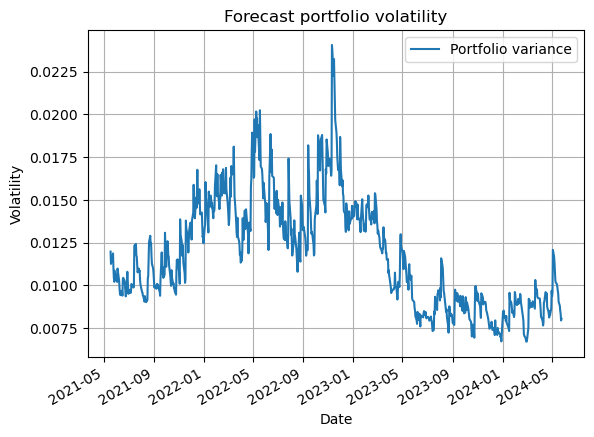

In [110]:
np.sqrt(portfolio_variance).plot()
plt.title('Forecast portfolio volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()
plt.show()

In [136]:
portfolio_returns = df_log_returns.loc[fitted_weights.index,:] * fitted_weights 
portfolio_returns = portfolio_returns.sum(axis=1)

In [137]:
portfolio_returns

2021-05-18 00:00:00-04:00   -0.001708
2021-05-19 00:00:00-04:00    0.002638
2021-05-20 00:00:00-04:00    0.020234
2021-05-21 00:00:00-04:00   -0.007001
2021-05-24 00:00:00-04:00    0.017846
                               ...   
2024-05-20 00:00:00-04:00    0.005856
2024-05-21 00:00:00-04:00    0.004630
2024-05-22 00:00:00-04:00    0.000067
2024-05-23 00:00:00-04:00   -0.032133
2024-05-24 00:00:00-04:00    0.010484
Length: 761, dtype: float64

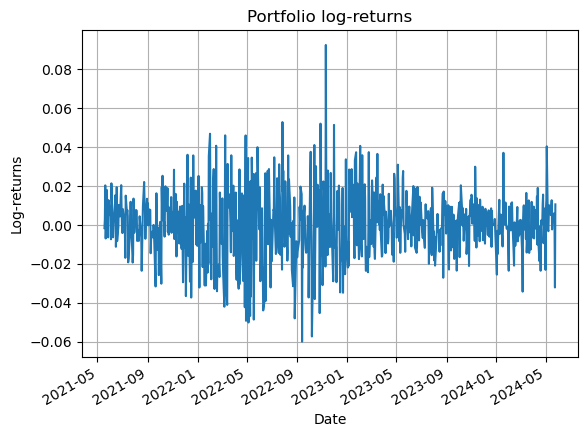

In [141]:
portfolio_returns.plot()
plt.title('Portfolio log-returns')
plt.xlabel('Date')
plt.ylabel('Log-returns')
plt.grid()
plt.show()

### Let's compute the VaR

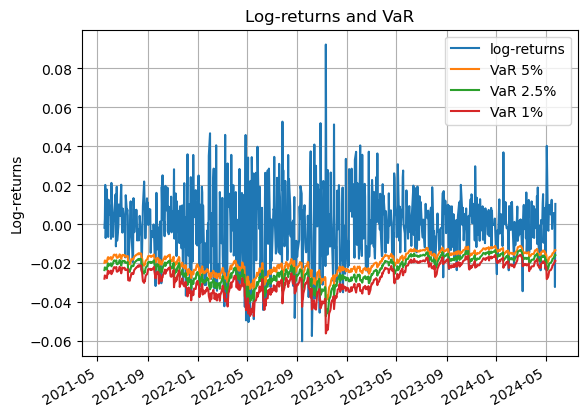

In [143]:
VaR005 = norm.ppf(0.05) * np.sqrt(np.array(portfolio_variance.iloc[:,:]))
VaR025 = norm.ppf(0.025) * np.sqrt(np.array(portfolio_variance.iloc[:,:]))
VaR001 = norm.ppf(0.01) * np.sqrt(np.array(portfolio_variance.iloc[:,:]))

portfolio_returns.plot()
plt.plot(portfolio_returns.index, VaR005)
plt.plot(portfolio_returns.index, VaR025)
plt.plot(portfolio_returns.index, VaR001)
plt.grid()
plt.title('Log-returns and VaR')
#plt.xlabel('Date')
plt.ylabel('Log-returns')

plt.legend(['log-returns','VaR 5%','VaR 2.5%','VaR 1%'])
plt.show()

### Let's compute the Expected Shortfall

In [144]:
def gaussian_ES(mu, vol, alpha):
    
    return mu + vol * norm.pdf(norm.ppf(alpha))/(1-alpha)

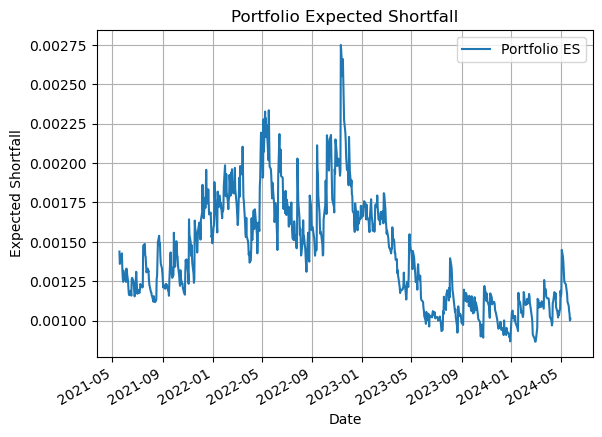

In [161]:
portfolio_ES = np.empty(len(portfolio_variance.index))
mu = np.mean(portfolio_returns.loc[portfolio_variance.index])

for i,day in enumerate(portfolio_variance.index):
    
    # r = float(portfolio_returns.loc[day])
    sigma = np.sqrt(float(portfolio_variance.loc[day]))
    portfolio_ES[i] = gaussian_ES(mu, sigma, .05)
    


portfolio_ES = pd.DataFrame(data=portfolio_ES, columns=['Portfolio ES'], index=portfolio_variance.index)

portfolio_ES.plot()
plt.grid()
plt.title('Portfolio Expected Shortfall')
plt.ylabel('Expected Shortfall')
plt.xlabel('Date')
plt.show()